# Gaussian tvTAR(1)

times_T = 5000 | 
times_t_dict [[2400, 2410, 2430, 2440, 2460, 2470, 2490, 2500, 2510, 2530, 2540, 2560, 2570, 2590, 2600]] | 
n_replications = 10 | device = cpu
times_T = 10000 | 
times_t_dict [[4800, 4830, 4860, 4890, 4910, 4940, 4970, 5000, 5030, 5060, 5090, 5110, 5140, 5170, 5200]] | 
n_replications = 10 | device = cpu
times_T = 15000 | 
times_t_dict [[7200, 7240, 7290, 7330, 7370, 7410, 7460, 7500, 7540, 7580, 7630, 7670, 7710, 7760, 7800]] | 
n_replications = 10 | device = cpu
----------------------------------------------------------------------------------------------------
Simulation of L-replications with T-samples of process ...
Montecarlo 1 completed.
Montecarlo 2 completed.
Simulation completed; time elapsed = 0:00:01.032772.
----------------------------------------------------------------------------------------------------
Running computation weights for Montecarlo 1 starts at 2024-11-21 16:05:20.189241 ...
Weights computation complete for Montecarlo 1 at 2024-11-21 16:0

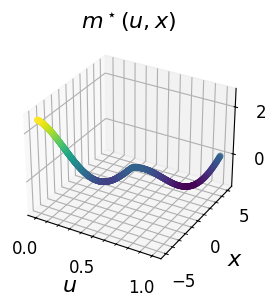

<Figure size 1000x300 with 0 Axes>

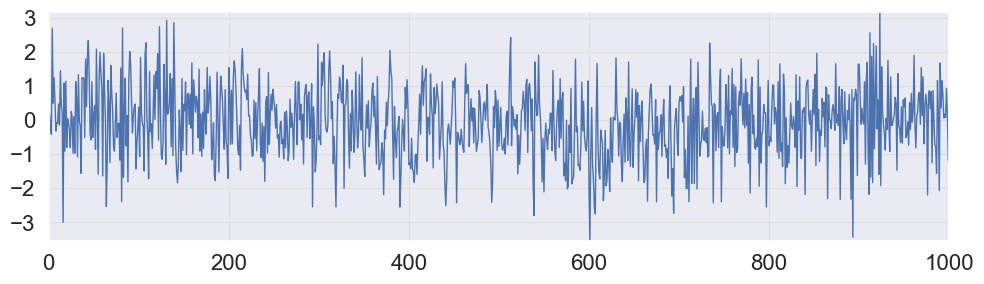

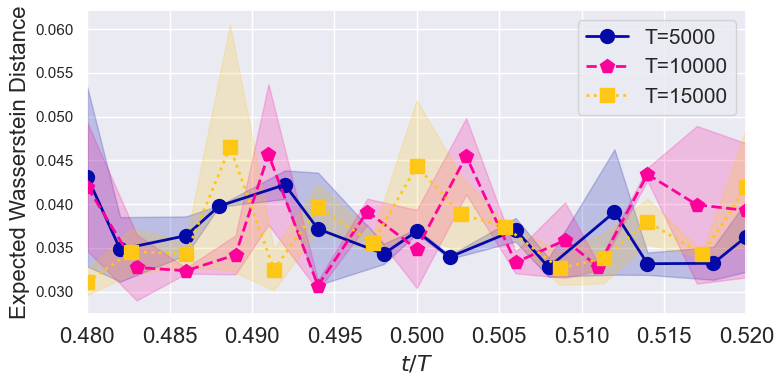

In [2]:
from models.GaussiantvTAR1 import main
main()